In [1]:
import numpy as np
import torch
import time
from torchvision.models import *
import pandas as pd
import os
import torchvision
from torch2trt import torch2trt
import torchvision.transforms

import matplotlib.pyplot as plt
from torchvision.models.segmentation import *

In [2]:
import cv2

In [3]:
FP32 = True
FP16 = True
INT8 = True

In [4]:
# make results
os.makedirs("results", exist_ok=True)

In [5]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)['out']

In [6]:
def computeTime(model, input_size=[1, 3, 224, 224], device='cuda', FP16=False):
    inputs = torch.randn(input_size)
    if device == 'cuda':
        model = model.cuda()
        inputs = inputs.cuda()
    if FP16:
        model = model.half()
        inputs = inputs.half()

    model.eval()

    i = 0
    time_spent = []
    while i < 200:
        start_time = time.time()
        with torch.no_grad():
            _ = model(inputs)

        if device == 'cuda':
            torch.cuda.synchronize() # wait for cuda to finish (cuda is asynchronous!)
        if i != 0:
            time_spent.append(time.time() - start_time)
        i += 1
    print('Avg execution time (ms): {:.3f}'.format(np.mean(time_spent)))
    return np.mean(time_spent)

In [7]:
# resnet is enought for now
modellist = ["fcn_resnet50", "fcn_resnet101", "deeplabv3_resnet50", "deeplabv3_resnet101"]

# read image dir
file = "imgs/_108240741_beatles-abbeyroad-square-reuters-applecorps.jpg"

In [8]:
def execute(x, model):
    with torch.no_grad():
        output = model(x)
    om = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
    return om

# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

def inference(model, img, imsize=None):
    # normalize
    mean = np.array([0.485, 0.456, 0.406])
    stdev = np.array([0.229, 0.224, 0.225])
    normalize = torchvision.transforms.Normalize(mean, stdev)
    # device
    device = "cuda"

    # Apply the transformations needed
    import torchvision.transforms as T
    if imsize==None:
        trf = T.Compose([#T.Resize(256),
                         #T.CenterCrop(224),
                         T.ToTensor(), 
                         T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])])
    else:
        trf = T.Compose([T.Resize(imsize),
                         T.CenterCrop(imsize),
                         T.ToTensor(), 
                         T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])])
    
    img2 = trf(img).unsqueeze(0).cuda().float()
    mask = execute(img2, model)
    return mask

def get_img_tensor(img, imsize=None):
    # normalize
    mean = np.array([0.485, 0.456, 0.406])
    stdev = np.array([0.229, 0.224, 0.225])
    normalize = torchvision.transforms.Normalize(mean, stdev)
    # device
    device = "cuda"

    # Apply the transformations needed
    import torchvision.transforms as T
    if imsize==None:
        trf = T.Compose([#T.Resize(256),
                         #T.CenterCrop(224),
                         T.ToTensor(), 
                         T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])])
    else:
        trf = T.Compose([T.Resize(imsize),
                         T.CenterCrop(imsize),
                         T.ToTensor(), 
                         T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])])
    
    return trf(img).unsqueeze(0).cuda().float()

In [9]:
def show_results(file, mask, imsize=None, watermark="normal"):
    # load figs
    plt.figure(figsize=(10,10))
    imgshow = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)/255
    if imsize != None:
        imgshow = cv2.resize(imgshow, (imsize,imsize))
    plt.imshow(imgshow)
    plt.show()

    # decode segmap
    rgb = decode_segmap(mask)
    plt.figure(figsize=(10,10))
    plt.imshow(rgb)
    plt.imsave("imgs/mask"+watermark+".jpg", rgb)
    plt.show()

    # show overlay
    plt.figure(figsize=(10,10))
    img = np.clip(imgshow*0.5 + (rgb)/255, 0, 1)
    plt.imshow(img)
    plt.imsave("imgs/add"+watermark+".jpg", img)
    plt.show()


# Try segmentation inference

raw pytorch model


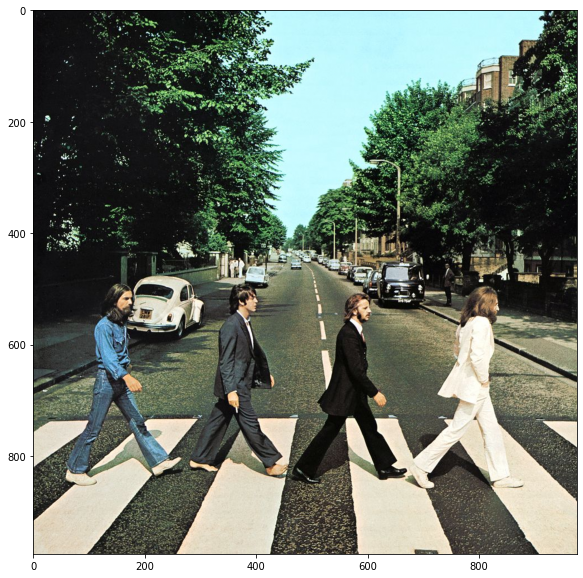

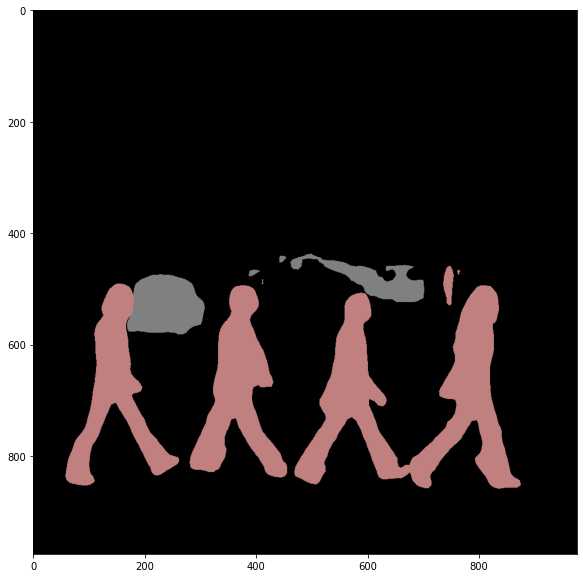

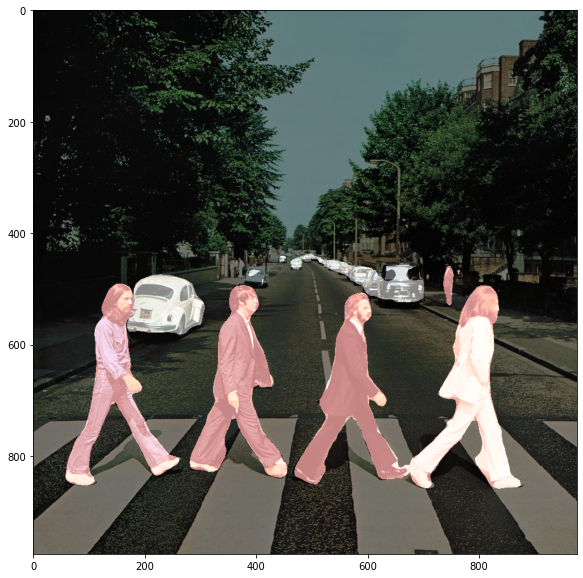

In [10]:
from PIL import Image
img = Image.open(file)

print("raw pytorch model")
mdl = globals()[modellist[1]]
model = ModelWrapper(mdl(pretrained=True).cuda().eval())
mask = inference(model, img)

show_results(file, mask)

# Try segmentation inference with smaller image size

imsize: 256


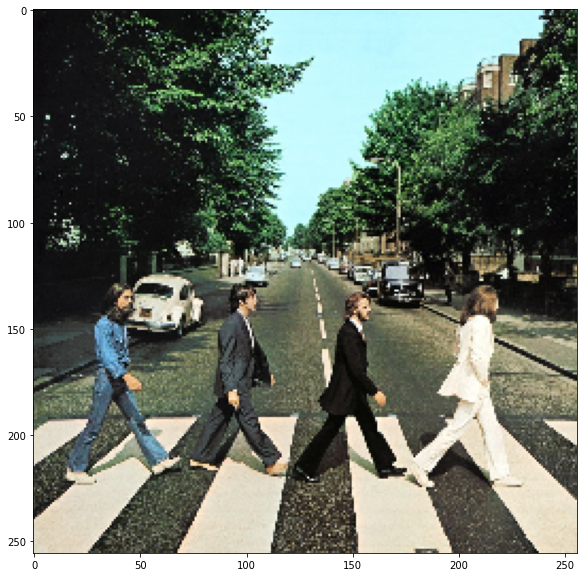

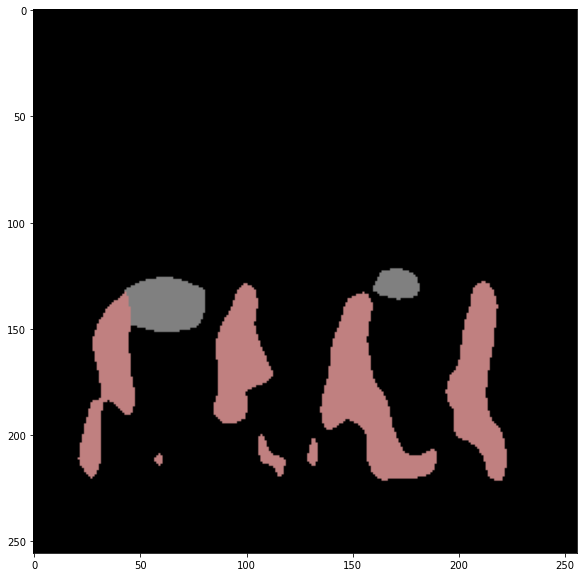

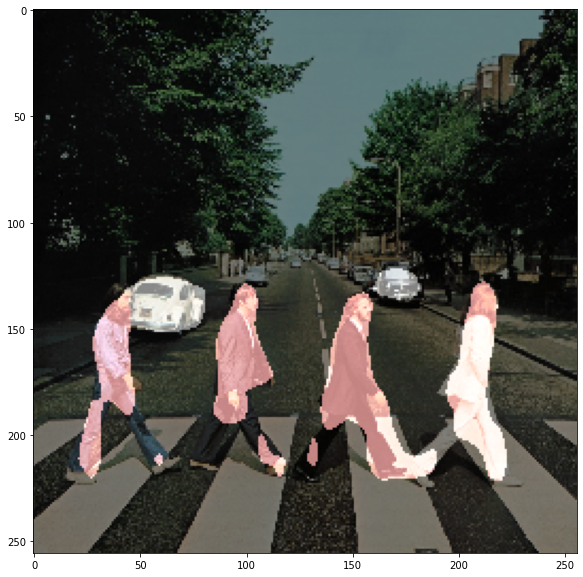

imsize: 512


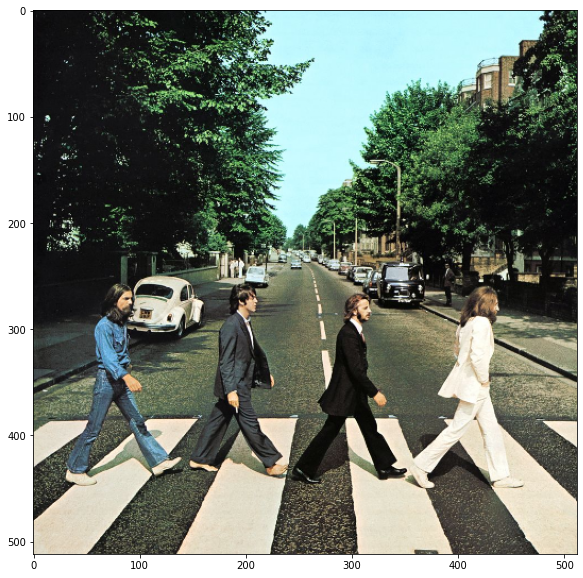

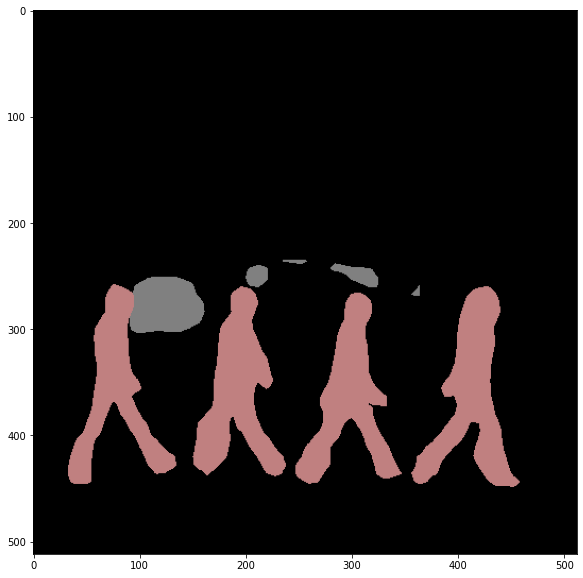

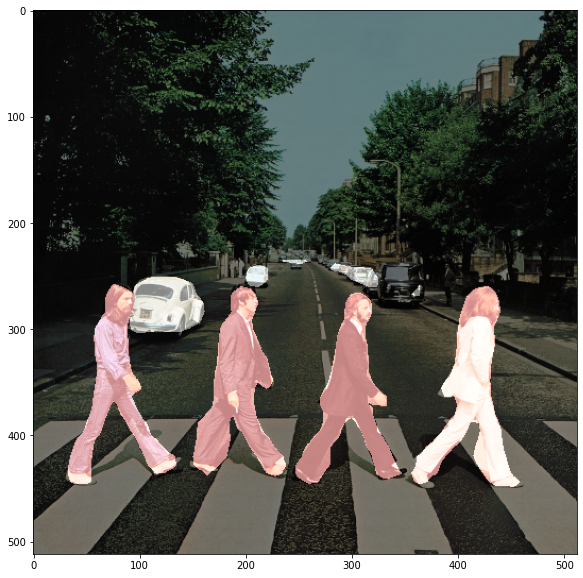

imsize: 768


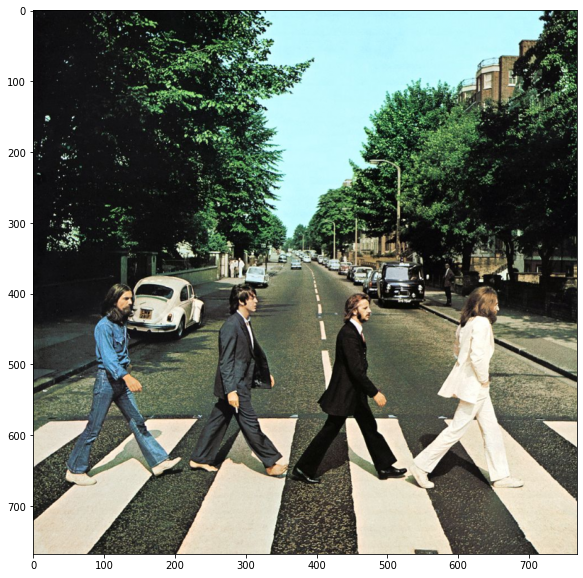

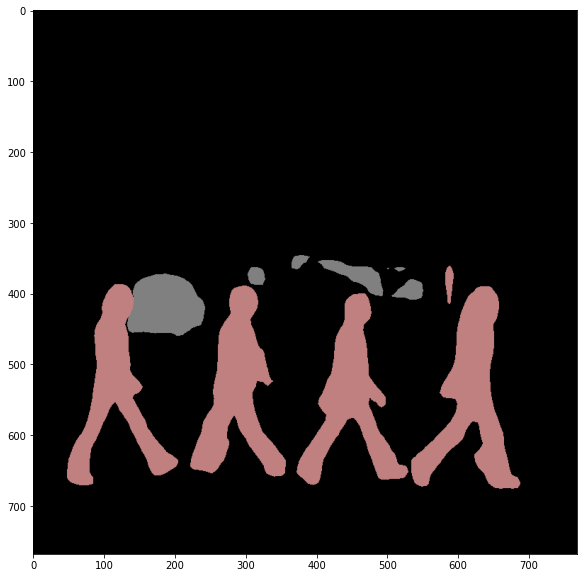

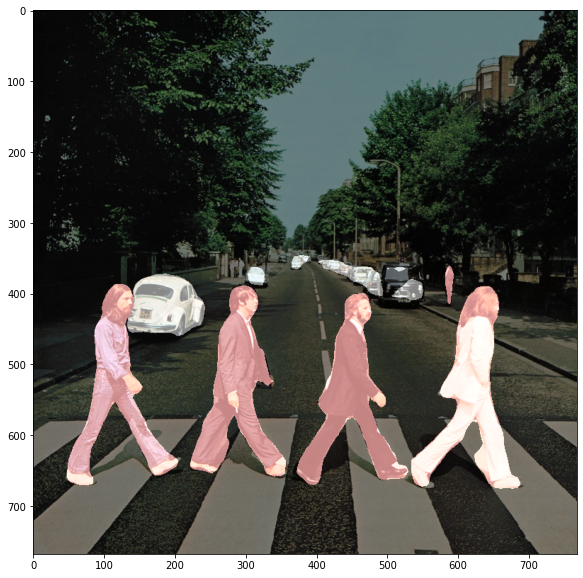

In [11]:
from PIL import Image
img = Image.open(file)

for imsize in [256, 512, 768]:
    print("imsize: {}".format(imsize))
    mdl = globals()[modellist[1]]
    model = ModelWrapper(mdl(pretrained=True).cuda().eval())
    mask = inference(model, img, imsize)

    show_results(file, mask, imsize, watermark=str(imsize))

# Try segmentation with TensorRT

In [ ]:
from PIL import Image
img = Image.open(file)

print("TensorRT FP32")
mdl = globals()[modellist[1]]
model = ModelWrapper(mdl(pretrained=True).cuda().eval())
# convert to tensorrt models
x = get_img_tensor(img)
model_trt = torch2trt(model, [x])
# infer
mask = inference(model_trt, img)

show_results(file, mask, watermark="tensorrt_FP32")

TensorRT FP32


In [ ]:
from PIL import Image
img = Image.open(file)

print("TensorRT FP16")
mdl = globals()[modellist[1]]
model = ModelWrapper(mdl(pretrained=True).cuda().eval())
# convert to tensorrt models
x = get_img_tensor(img)
model_trt = torch2trt(model, [x], fp16_mode=True)
# infer
mask = inference(model_trt, img)

show_results(file, maskk, watermark="tensorrt_FP16")

In [ ]:
from PIL import Image
img = Image.open(file)

print("TensorRT INT8")
mdl = globals()[modellist[1]]
model = ModelWrapper(mdl(pretrained=True).cuda().eval())
# convert to tensorrt models
x = get_img_tensor(img)
model_trt = torch2trt(model, [x], fp16_mode=True, int8_mode=True, max_batch_size=1)
# infer
mask = inference(model_trt, img)

show_results(file, maskk, watermark="tensorrt_INT8")